<a href="https://colab.research.google.com/github/yunju-1118/EWHA/blob/main/softmax_classification_mnist_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **라이브러리 불러오기**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision.datasets import MNIST, CIFAR10, CIFAR100
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

## **데이터셋 로드 & 전처리**

In [ ]:
path = './datasets/'

transform = transforms.Compose([transforms.ToTensor()])

#### HERE ####
train_data = MNIST(root=path, train=True, transform=transform, download=True)
test_data = MNIST(root=path, train=False, transform=transform, download=True)

batch_size = 100

#### HERE ####
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, num_workers=4)

print(train_data)
print(test_data)

input_shape = train_data[0][0].reshape(-1).shape[0]    # 1*28*28 = 784 features
output_shape = len(train_data.classes)  # sum-to-one probability 예측을 위함

print(input_shape,output_shape)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./datasets/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./datasets/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
784 10


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## **모델 정의**

### **version 1**

In [ ]:
class SoftmaxClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        #### HERE ####
        # input_dim = 784 - 256 - 256 - 256 - ouput_dim = 10
        self.linear1 = nn.Linear(input_shape, 256)    # weight.dim = (784,256), bias.dim(256)
        self.linear2 = nn.Linear(256, 256)
        self.linear3 = nn.Linear(256, 256)
        self.linear4 = nn.Linear(256, output_shape)


    def forward(self,x):
        #### HERE ####
        # view: (batch_size, 1, 28, 28) -> (batch_size, 784)
        hidden = F.leaky_relu(self.linear1(x.view(batch_size, -1)))
        hidden = F.leaky_relu(self.linear2(hidden))
        hidden = F.leaky_relu(self.linear3(hidden))
        output = self.linear4(hidden)     # not F.softmax(self.linear4(hidden), dim=-1) // logit


        #### HERE ####
        return output

### **version 2**

In [ ]:
class SoftmaxClassifier(nn.Module):
    def __init__(self):
        ## 모델의 구조 정의
        super().__init__()
        # 1*28*28 -> 784
        self.layers = nn.Sequential(
                      nn.Flatten(),
                      nn.Linear(input_shape, 512),
                      nn.LeakyReLU(),
                      # nn.Dropout(),
                      nn.Linear(512,256),
                      nn.LeakyReLU(),
                      # nn.Dropout(),
                      nn.Linear(256,128),
                      nn.LeakyReLU(),
                      # nn.Dropout(),
                      nn.Linear(128, output_shape))


    def forward(self,x):

        ## 모델의 연산 흐름 정의
        return self.layers(x)

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps:0")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device)

model = SoftmaxClassifier().to(device)
loss = nn.CrossEntropyLoss(reduction='mean')

# minimize loss
# minimize loss' = loss + weight_decay * l2_regularization
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# L2 regularization 적용
## optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-3)

# Adam 이용
## optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) => 빠른 학습 속도

cuda:0


In [ ]:
num_epoch = 100
train_loss_list, test_loss_list = list(), list()

for i in range(num_epoch):

    ## train
    model.train()

    total_loss = 0
    count = 0

    for batch_idx, (x, y) in enumerate(train_loader):
        # MNIST: x.shape = (100, 1, 28, 28) => (100,784), y.shape = (100,1) = (100,)

        x, y = x.to(device), y.to(device)

        pre_y_est = model.forward(x)    ## Forward computatio
        cost = loss(pre_y_est, y)   ## Loss 계산
        y_est = F.softmax(pre_y_est, dim=-1)    ## 유사 확률값 계산

        total_loss += cost.item() * len(x)  ## epoch의 전체 손실 계산

        # for param in model.parameters():
            # cost += torch.norm(param,1)*0.001   # L1 regularization

        #### HERE ####
        optimizer.zero_grad()   # gradient 초기화
        cost.backward()     # back-propagation
        optimizer.step()    # update w

        pred = torch.argmax(y_est,dim=-1)
        count += (pred == y).sum().item()

    acc = count/len(train_data)
    ave_loss = total_loss/len(train_data)

    train_loss_list.append(ave_loss)

    if i % 1 == 0:
        print("\nEpoch %d Train: %.3f / %.3f"%(i,ave_loss,acc))

    ## test
    model.eval()

    total_loss = 0
    count = 0

    #### HERE ####
    with torch.no_grad():
        for batch_idx, (x,y) in enumerate(test_loader):
            x,y = x.to(device), y.to(device)

            pre_y_est = model.forward(x)
            cost = loss(pre_y_est, y)
            y_est = F.softmax(pre_y_est, dim=-1)

            total_loss += cost.item()*len(x)

            pred = torch.argmax(y_est, dim=-1)
            count += (pred==y).sum().item()

    acc = count/len(test_data)
    ave_loss = total_loss/len(test_data)

    test_loss_list.append(ave_loss)

    if i % 1 == 0:
        print("Epoch %d Test: %.3f / %.3f"%(i,ave_loss,acc))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 0 Train: 0.834 / 0.769
Epoch 0 Test: 0.783 / 0.784

Epoch 1 Train: 0.778 / 0.781
Epoch 1 Test: 0.732 / 0.793

Epoch 2 Train: 0.731 / 0.791
Epoch 2 Test: 0.690 / 0.805

Epoch 3 Train: 0.692 / 0.801
Epoch 3 Test: 0.654 / 0.815

Epoch 4 Train: 0.659 / 0.811
Epoch 4 Test: 0.623 / 0.823

Epoch 5 Train: 0.630 / 0.819
Epoch 5 Test: 0.596 / 0.828

Epoch 6 Train: 0.605 / 0.827
Epoch 6 Test: 0.574 / 0.836

Epoch 7 Train: 0.584 / 0.832
Epoch 7 Test: 0.553 / 0.841

Epoch 8 Train: 0.564 / 0.839
Epoch 8 Test: 0.535 / 0.846

Epoch 9 Train: 0.547 / 0.843
Epoch 9 Test: 0.519 / 0.850

Epoch 10 Train: 0.532 / 0.848
Epoch 10 Test: 0.505 / 0.854

Epoch 11 Train: 0.518 / 0.853
Epoch 11 Test: 0.491 / 0.859

Epoch 12 Train: 0.505 / 0.856
Epoch 12 Test: 0.480 / 0.863

Epoch 13 Train: 0.494 / 0.860
Epoch 13 Test: 0.469 / 0.866

Epoch 14 Train: 0.483 / 0.863
Epoch 14 Test: 0.460 / 0.867

Epoch 15 Train: 0.473 / 0.865
Epoch 15 Test: 0.450 / 0.870

Epoch 16 Train: 0.464 / 0.868
Epoch 16 Test: 0.442 / 0.873


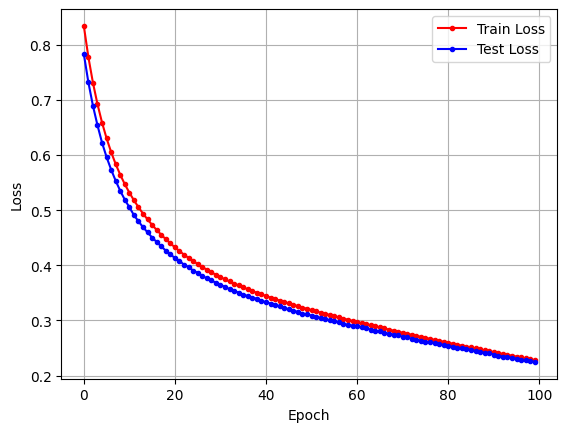

In [ ]:
import matplotlib.pyplot as plt

x_len = np.arange(len(train_loss_list))
plt.plot(x_len, train_loss_list, marker='.', c='red', label='Train Loss')
plt.plot(x_len, test_loss_list, marker='.', c='blue', label = 'Test Loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
num_parameter = 0
for parameter in model.parameters():
    print(parameter.shape)
    num_parameter += np.prod(parameter.size())
print(num_parameter)

torch.Size([512, 784])
torch.Size([512])
torch.Size([256, 512])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])
567434
